# Exemple des méthodes de fiabilité
Ce notebook vise à illustrer l'utilisation des méthodes de fiabilité.

In [1]:
import openturns as ot
from openturns.viewer import View
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pythontools
rcParams = { 'axes.grid': False,
             'axes.labelsize': 16,
             'xtick.labelsize': 12,
             'ytick.labelsize': 12,
             'axes.linewidth': 0.5,
             'font.size': 16,
             'image.cmap': 'gray',
             'image.interpolation': 'bilinear',
             'legend.fontsize': 16,
             'legend.shadow': True,
             'lines.linewidth': 1.5}
plt.rcParams.update(rcParams)
light_gray = plt.matplotlib.colors.LinearSegmentedColormap.from_list(
                'light_gray', [[.9] * 3, [.6] * 3])
class FormatFaker(object):
    def __init__(self, str): self.str = str
    def __mod__(self, stuff): return self.str

## Définition d'un problème de fiabilité

3 problèmes sont activables !

### Exemple 1 : R - S

In [2]:
## Définition du modèle probabiliste des paramètres d'entrée
R = ot.LogNormalMuSigma(7., .5, 0.).getDistribution()
R.setDescription(['Resistance'])
S = ot.LogNormalMuSigma(1., .5, 0.).getDistribution()
S.setDescription(['Contrainte'])

spearman_rank_correlation = ot.CorrelationMatrix(2)
spearman_rank_correlation[0, 1] = .525
copula = ot.NormalCopula(spearman_rank_correlation)
input_distribution = ot.ComposedDistribution([R, S], copula)
input_distribution

## Définition de la fonction d'état-limite
g = ot.SymbolicFunction(['r', 's'], ['r - s'])
g = ot.MemoizeFunction(g)
g.enableHistory()
g.setOutputDescription(['g'])

## Définition de la marge
G = ot.CompositeRandomVector(g, ot.RandomVector(input_distribution))
G.setDescription(['Marge'])

## Définition de l'évènement redouté
failure = ot.ThresholdEvent(G, ot.LessOrEqual(), 0.)
failure.setDescription(["La contrainte dépasse la résistance"])

### Exemple 2 : Der Kiureghian & Dakessian (1998)

Un exemple à deux "points de défaillance les plus probables" pour montrer les limites des approches basées sur l'hypothèse d'unicité d'un tel point (FORM, SORM, et MPFP-IS)

Dans cet exemple, la fonction d'état-limite est définie comme suit:

$g(x_1, x_2) = b - x_2 - \kappa\,(x_1 - e) ^ 2$,

et $\mathbf{X} \sim \mathcal{N}_2(\mathbf{0}, \mathbf{1})$.

Le paramètre d'excentricité $e > 0$ permet de favoriser l'influence un point de défaillance plutôt qu'un autre dans la probabilité, le coefficient $\kappa > 0$ contrôle la courbure de l'état-limite.

###  Exemple 3 : Du disque au rectangle (perte de gradient)

Un état-limite de type "circulaire" que l'on peut faire tendre vers un "rectangle" en manipulant l'exposant $k$.

Dans cet exemple, la fonction d'état-limite est définie comme suit:

$g(x_1, x_2) = s\,\left[\left((x_1 - c_1)^{2\,k} + (x_2 - c_2)^{2\,k}\right) - r^{2\,k}\right]$,

et $\mathbf{X} \sim \mathcal{N}_2(\mathbf{0}, \mathbf{1})$.

Le coefficient $s \in \{-1; 1\}$ contrôle le sens dans lequel on définit la défaillance: l'intérieur ($s = 1$) ou l'extérieur ($s = -1$) du cercle de centre de coordonnées $\mathbf{c} = (c_1,\,c_2)^{\mathrm T}$.

En augmentant l'exposant $k$, la fonction d'état-limite s'applatit au voisinage du centre  rendant ainsi la plupart des méthodes fiabilistes impuissantes, car la plupart s'appuie sur l'existence d'un gradient non-nul pour guider progressivement les simulations vers la défaillance.

#### Transformation isoprobabiliste et représentations 2D du problème

La *transformation isoprobabiliste* programmée dans **OpenTURNS** permet systématiquement de se ramener d'un vecteur aléatoire quelconque à un vecteur aléatoire gaussien de moyenne nulle et de covariance unitaire.

Cette *standardisation* du problème permet:

- de construire de bonnes approximations de la probabilité de l'évènement redouté (voir les méthodes FORM/SORM) ;
- de régler les autres algorithmes de manière robuste (*i.e.* indépendamment de l'ordre de grandeur des variables du problème).

Examinons ses effets par des représentations 2D.

In [3]:
def plot_in_standard_space(lim=6, res=50, ax=None, g0=0.):
    if ax is None:
        ax = plt.figure(figsize=(8, 8)).add_subplot(111)
    u1_plot, u2_plot = np.meshgrid(np.linspace(-lim, lim, res), np.linspace(-lim, lim, res))
    uu_plot = np.vstack([u1_plot.ravel(), u2_plot.ravel()]).T
    Tinv = input_distribution.getInverseIsoProbabilisticTransformation()
    gu_plot = np.reshape(g(Tinv(uu_plot)), (res, res))
    fu_plot = np.reshape(ot.Normal(2).computePDF(uu_plot), (res, res))
    im = ax.imshow(np.flipud(fu_plot), cmap=light_gray, extent=(-lim, lim, -lim, lim))
    cb = plt.colorbar(im)
    cb.set_label('$\\varphi(\mathbf{u})$')
    if g0 is not None:
        ax.contourf(u1_plot, u2_plot, gu_plot, [-np.inf, g0], colors='r', alpha=.2)
        c = ax.contour(u1_plot, u2_plot, gu_plot, [g0], colors='r', linestyles='solid')
        plt.clabel(c, fmt=FormatFaker('$g^{\circ}(\mathbf{u}) = %.2f$' % g0))
    ax.set_title('Standard space')
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect(1.)
    ax.set_xlabel('$u_1$')
    ax.set_ylabel('$u_2$')
    origin = np.zeros(2)
    ax.plot(origin[0], origin[1], 'k.', markersize=15)
    plt.text(origin[0], origin[1], '$\mathbf{O}$', ha='left', va='bottom', fontdict={'fontsize': 14})
    plt.axvline(origin[0], color='k', linestyle='dashdot', linewidth=1.)
    plt.axhline(origin[1], color='k', linestyle='dashdot', linewidth=1.)
    return ax, locals()

In [4]:
def plot_in_physical_space(lim=6, res=50, ax=None, g0=0.):
    if ax is None:
        ax = plt.figure(figsize=(8, 8)).add_subplot(111)
    x1_lim = (input_distribution.getMarginal(0).computeQuantile(ot.Normal().computeCDF(-lim))[0],
              input_distribution.getMarginal(0).computeQuantile(1. - ot.Normal().computeCDF(-lim))[0])
    x2_lim = (input_distribution.getMarginal(1).computeQuantile(ot.Normal().computeCDF(-lim))[0],
              input_distribution.getMarginal(1).computeQuantile(1. - ot.Normal().computeCDF(-lim))[0])
    x1_plot, x2_plot = np.meshgrid(np.linspace(x1_lim[0], x1_lim[1], res),
                                   np.linspace(x2_lim[0], x2_lim[1], res))
    xx_plot = np.vstack([x1_plot.ravel(), x2_plot.ravel()]).T
    gx_plot = np.reshape(g(xx_plot), (res, res))
    fx_plot = np.reshape(input_distribution.computePDF(xx_plot), (res, res))
    im = ax.imshow(np.flipud(fx_plot), cmap=light_gray, extent=(x1_lim[0], x1_lim[1], x2_lim[0], x2_lim[1]))
    cb = plt.colorbar(im)
    cb.set_label('$f_{\mathbf{X}}(\mathbf{x})$')
    if g0 is not None:
        ax.contourf(x1_plot, x2_plot, gx_plot, [-np.inf, g0], colors='r', alpha=.2)
        c = ax.contour(x1_plot, x2_plot, gx_plot, [g0], colors='r', linestyles='solid')
        plt.clabel(c, fmt=FormatFaker('$g(\mathbf{x}) = %.2f$' % g0))
    ax.set_title('Physical space')
    ax.set_xlim(*x1_lim)
    ax.set_ylim(*x2_lim)
    #ax.set_aspect(np.diff(x1_lim) / np.diff(x2_lim))
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    median = input_distribution.computeQuantile(.5)
    ax.plot(median[0], median[1], 'k.', markersize=15)
    plt.text(median[0], median[1], '$\mathbf{X}_{50\%}$', ha='left', va='bottom', fontdict={'fontsize': 14})
    plt.axvline(median[0], color='k', linestyle='dashdot', linewidth=1.)
    plt.axhline(median[1], color='k', linestyle='dashdot', linewidth=1.)
    return ax, locals()

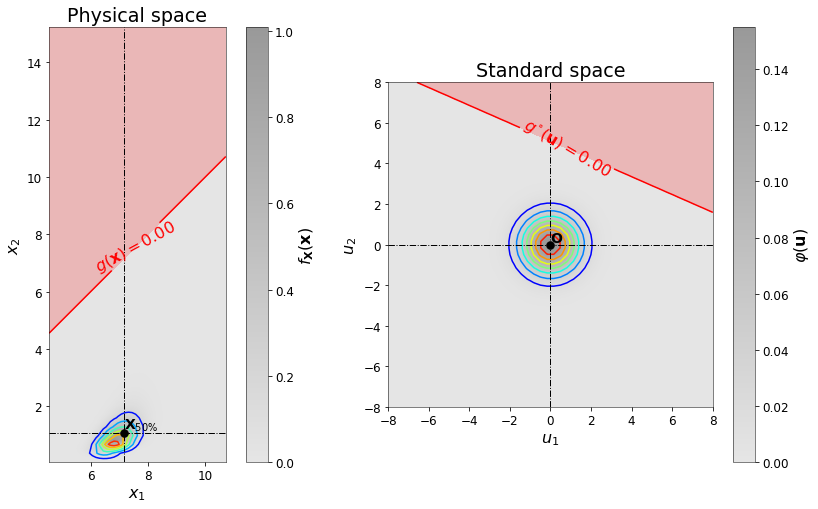

In [5]:
fig = plt.figure(figsize=(16, 8))
ax, data_plot = plot_in_physical_space(ax=fig.add_subplot(121))
_ = ax.contour(data_plot['x1_plot'], data_plot['x2_plot'], data_plot['fx_plot'], cmap=plt.matplotlib.cm.jet)
ax, data_plot = plot_in_standard_space(ax=fig.add_subplot(122), lim=8.)
_ = ax.contour(data_plot['u1_plot'], data_plot['u2_plot'], data_plot['fu_plot'], cmap=plt.matplotlib.cm.jet)

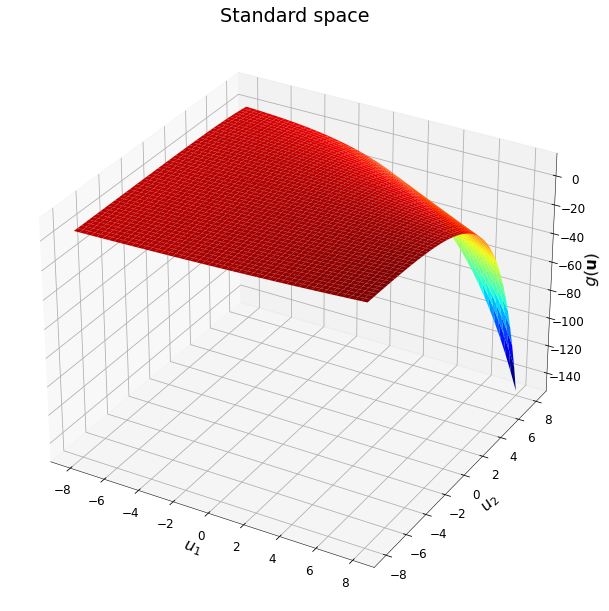

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)
ax.plot_surface(data_plot['u1_plot'], data_plot['u2_plot'], data_plot['gu_plot'],
                cmap=plt.matplotlib.cm.jet, rstride=1, cstride=1, lw=0.)
ax.set_xlabel('$u_1$')
ax.set_ylabel('$u_2$')
ax.set_zlabel('$g(\mathbf{u})$')
_ = ax.set_title('Standard space')

La transformation isoprobabiliste *conserve les probabilités*, donc la probabilité de défaillance calculée dans l'espace physique est **la même** que celle calculée dans l'espace standard. Néanmoins, ses approximations peuvent être **différentes** d'un espace à l'autre car la géométrie n'est pas la même.

## Estimation par simple simulation de Monte Carlo

La simulation de Monte Carlo est la méthode d'estimation de référence. Néanmoins, son coût de calcul est inversement proportionnel à la probabilité à estimer, ce qui la rend tout simplement innaplicable dès lors que la probabilité est faible et le modèle coûteux à évaluer.

In [7]:
g.clearHistory()
mcs_result = pythontools.run_monte_carlo(failure, coef_var=0.1, outer_sampling=2000, block_size=1000,
                                         verbose=True, logfile=True)


 Result - Monte Carlo
 --------------------------------------------------------------------
 Probability of failure = 2.50e-06
 Coefficient of varation = 0.447 
 95 % Confidence length = 4.38e-06
 Number of calls = 2000000 
 --------------------------------------------------------------------


In [8]:
# accès au fichier log avec tous les calculs à la fin de chaque bloc
!tail MonteCarlo.log

INF - probabilityEstimate=2.500000e-06 varianceEstimate=1.251247e-12 standard deviation=1.12e-06 coefficient of variation=4.47e-01 confidenceLength(0.95)=4.38e-06 outerSampling=2000 blockSize=1000
USR - 
 Result - Monte Carlo
 --------------------------------------------------------------------
 Probability of failure = 2.50e-06
 Coefficient of varation = 0.447 
 95 % Confidence length = 4.38e-06
 Number of calls = 2000000 
 --------------------------------------------------------------------
USR - -------------------------------------------------------------------


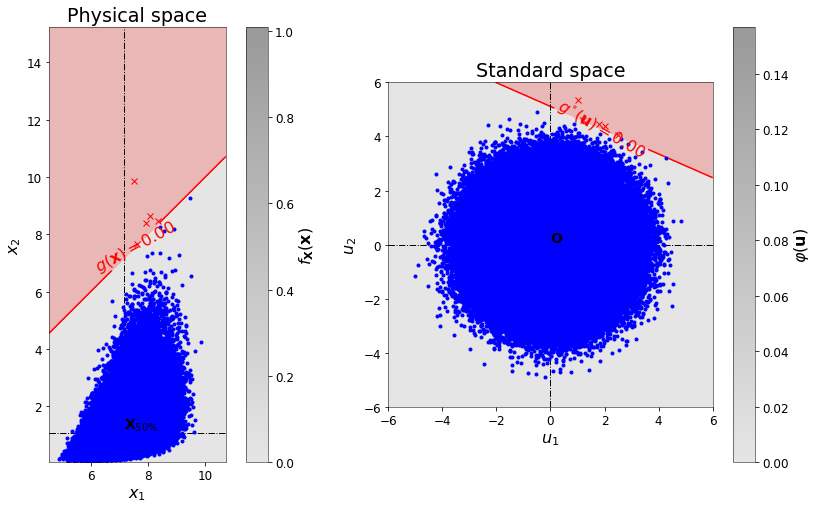

In [9]:
nb_pt_to_plot = int(1e7)
fig = plt.figure(figsize=(16, 8))
input_sample = np.array(g.getInputHistory())[:nb_pt_to_plot]
output_sample = np.ravel(g.getOutputHistory())[:nb_pt_to_plot]
ax, data_plot = plot_in_physical_space(ax=fig.add_subplot(121))
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')
ax, data_plot = plot_in_standard_space(ax=fig.add_subplot(122))
input_sample = np.array(input_distribution.getIsoProbabilisticTransformation()(input_sample))
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
_ = ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')

### Score function

In [10]:
def sensitivity_elasticity_on_pf(simu_result):
    dim = input_distribution.getParameterDimension() - 1
    simu_sensitivity = ot.SimulationSensitivityAnalysis(simu_result)
    sensitivity_pf = simu_sensitivity.computeEventProbabilitySensitivity()
    elasticity_pf = sensitivity_pf * np.abs(input_distribution.getParameter()[:dim] / 
                                     simu_result.getProbabilityEstimate())
    return sensitivity_pf, elasticity_pf

,sensitivities,elasticities
muLog_marginal_0,0.006243,4852.604087
sigmaLog_marginal_0,0.121684,3472.264829
gamma_marginal_0,-0.000331,-0.000000
muLog_marginal_1,0.008657,386.350530
sigmaLog_marginal_1,0.045881,8669.372932
gamma_marginal_1,0.000830,0.000000


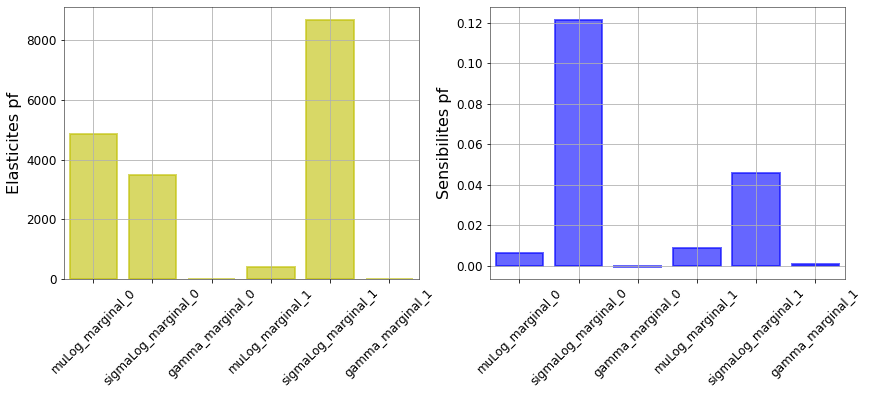

In [11]:
labels = input_distribution.getParameterDescription()[:-1]
sensitivity_pf, elasticity_pf = sensitivity_elasticity_on_pf(mcs_result)

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(121)
ax.bar(np.arange(len(labels)), elasticity_pf, color='y', ec='y', lw=2., alpha=.6)
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45., ha='center')
ax.set_xlim(-0.5, len(labels) - .5)
ax.set_ylabel('Elasticites pf')
ax.grid()
ax = fig.add_subplot(122)
ax.bar(np.arange(len(labels)), sensitivity_pf, color='b', ec='b', lw=2., alpha=.6)
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45., ha='center')
ax.set_xlim(-0.5, len(labels) - .5)
ax.set_ylabel('Sensibilites pf')
ax.grid()

labels = [label.replace('\n', ' ') for label in labels]
pd.DataFrame(dict(sensitivities=sensitivity_pf, elasticities=elasticity_pf),
             index=labels)

### Affichage de la CDF

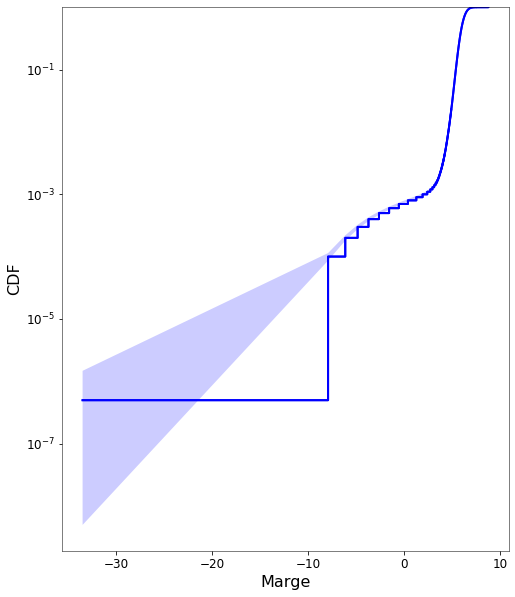

In [12]:
fig = plt.figure(figsize=(8, 10))
sample_G = g.getOutputHistory()
g_plot = np.sort(np.ravel(sample_G))[::int(sample_G.getSize() / 1e4)]
p_plot = np.ravel([sample_G.computeEmpiricalCDF([g_value]) for g_value in g_plot])
cov_plot = np.sqrt((1. - p_plot) / float(sample_G.getSize()) / p_plot)
p_plot_plus = p_plot * (1. + 1.96 * cov_plot)
p_plot_plus[p_plot_plus > 1.] = np.nan
p_plot_minus = p_plot * (1. - 1.96 * cov_plot)
p_plot_minus[p_plot_minus < p_plot.min() * 1e-2] = p_plot.min() * 1e-2
plt.plot(g_plot, p_plot, 'b-', drawstyle='steps-post', lw=2.)
plt.plot(g_plot, p_plot, 'b-', drawstyle='steps-post', lw=2.)
plt.fill_between(g_plot, p_plot_minus, p_plot_plus, facecolor='b', alpha=.2)
plt.yscale('log')
plt.xlabel(G.getDescription()[0])
plt.ylabel('CDF')
_ = plt.ylim(plt.ylim()[0], 1.)

## First order reliability method (FORM)

In [29]:
g.clearHistory()
form_result = pythontools.run_FORM(failure, nearest_point_algo='AbdoRackwitz',
                                   use_multi_form=False, verbose=True)


 Result - FORM (AbdoRackwitz)
 --------------------------------------------------------------------
 Probability of failure : 1.44e-06
 Generalised reliability index: 4.6794
 Number of iterations = 8
 Number of function calls = 26 
 Standard space design point:
[1.88249,4.28404]
 --------------------------------------------------------------------


### Affichage du / des point(s) de défaillance le(s) plus probable(s) (MPFP)

In [20]:
if form_result.getClassName() == 'MultiFORMResult':
    FORM_result_col = form_result.getFORMResultCollection()
    design_point_in_standard_space = [FORM_result_col[i].getStandardSpaceDesignPoint() 
                                          for i in range(len(FORM_result_col))]
    design_point_in_physical_space = [FORM_result_col[i].getPhysicalSpaceDesignPoint() 
                                          for i in range(len(FORM_result_col))]
    beta_list = [FORM_result_col[i].getGeneralisedReliabilityIndex() 
                                          for i in range(len(FORM_result_col))]
elif form_result.getClassName() == 'FORMResult':
    design_point_in_standard_space = [form_result.getStandardSpaceDesignPoint()]
    design_point_in_physical_space = [form_result.getPhysicalSpaceDesignPoint()]

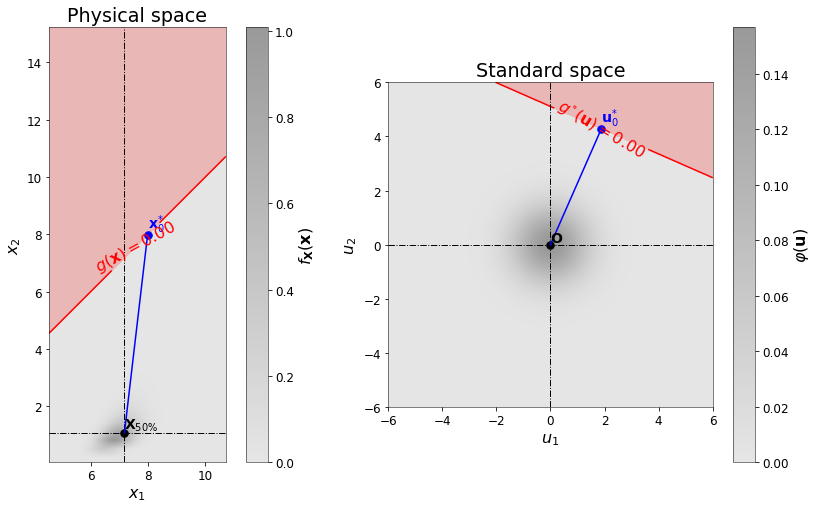

In [21]:
fig = plt.figure(figsize=(16, 8))
ax, data_plot = plot_in_physical_space(ax=fig.add_subplot(121))
for i in range(len(design_point_in_standard_space)):
    ax.plot([input_distribution.computeQuantile(.5)[0], design_point_in_physical_space[i][0]],
            [input_distribution.computeQuantile(.5)[1], design_point_in_physical_space[i][1]], 'b-')
    ax.plot(design_point_in_physical_space[i][0], design_point_in_physical_space[i][1],
            'b.', markersize=15)
    plt.text(design_point_in_physical_space[i][0], design_point_in_physical_space[i][1],
            '$\mathbf{x}^{*}_%d$' %i, ha='left', va='bottom', color='b', fontdict={'fontsize': 14})
ax, data_plot = plot_in_standard_space(ax=fig.add_subplot(122))
for i in range(len(design_point_in_standard_space)):
    ax.plot([0., design_point_in_standard_space[i][0]],
            [0., design_point_in_standard_space[i][1]], 'b-')
    ax.plot(design_point_in_standard_space[i][0], design_point_in_standard_space[i][1],
            'b.', markersize=15)
    plt.text(design_point_in_standard_space[i][0], design_point_in_standard_space[i][1],
            '$\mathbf{u}^{*}_%d$' %i, ha='left', va='bottom', color='b', fontdict={'fontsize': 14})
plt.show()

## Tirages d'importance

In [22]:
g.clearHistory()
is_result = pythontools.run_importance_sampling(failure, design_point_in_standard_space, verbose=True)


 Result - Importance Sampling
 --------------------------------------------------------------------
 Probability of failure = 1.61e-06
 Coefficient of varation = 0.100 
 95 % Confidence length = 6.29e-07
 Number of calls = 530 
 --------------------------------------------------------------------


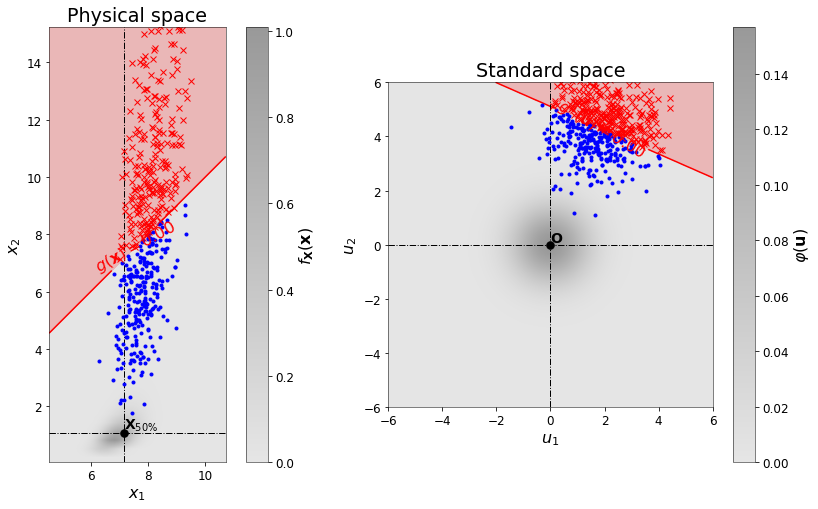

In [23]:
fig = plt.figure(figsize=(16, 8))
input_sample = np.array(g.getInputHistory())
output_sample = np.ravel(g.getOutputHistory())
ax, data_plot = plot_in_physical_space(ax=fig.add_subplot(121))
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')
ax, data_plot = plot_in_standard_space(ax=fig.add_subplot(122))
input_sample = np.array(input_distribution.getIsoProbabilisticTransformation()(input_sample))
# ax.contour(data_plot['u1_plot'], data_plot['u2_plot'],
#            np.reshape(instrumental_distribution.computePDF(data_plot['uu_plot']),
#                       data_plot['u1_plot'].shape),
#            cmap=plt.matplotlib.cm.jet)
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
_ = ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')

## Estimation par simulations directionnelles

In [24]:
g.clearHistory()
direc_result = pythontools.run_directional(failure, verbose=True)


 Result - Directional sampling
 --------------------------------------------------------------------
 Probability of failure = 1.38e-06
 Coefficient of varation = 0.098 
 95 % Confidence length = 5.30e-07
 Number of calls = 390 
 --------------------------------------------------------------------


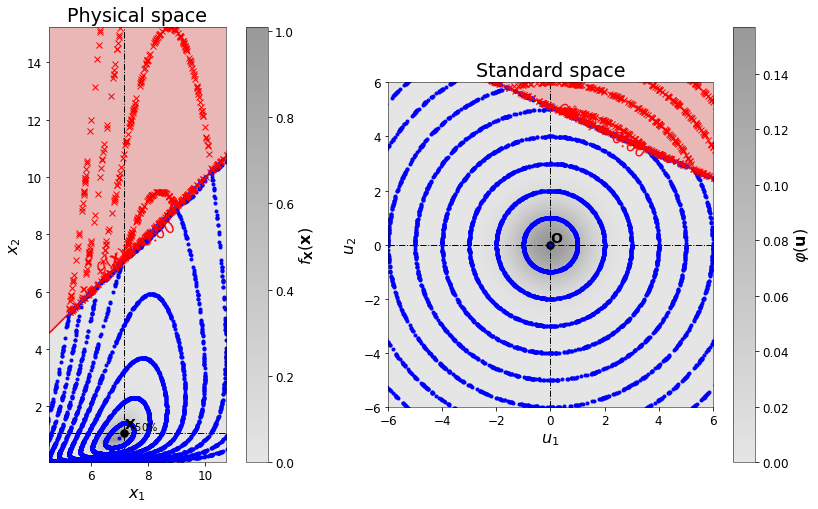

In [25]:
input_sample = np.array(g.getInputHistory())
output_sample = np.ravel(g.getOutputHistory())
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax, data_plot = plot_in_physical_space(ax=ax)
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')
ax = fig.add_subplot(122)
ax, data_plot = plot_in_standard_space(ax=ax)
input_sample = np.array(input_distribution.getIsoProbabilisticTransformation()(input_sample))
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
_ = ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')

## Estimation par subset sampling

In [26]:
g.clearHistory()
ss_algorithm = pythontools.run_subset(failure, verbose=True)


 Result - Method Subset
 --------------------------------------------------------------------
 Failure probability = 1.59e-06
 Coefficient of variation = 0.281
 95 % Confidence length = 1.76e-06
 Number of evaluations = 72000
 Number of steps = 6
 ------------------------------------------------------------------- 


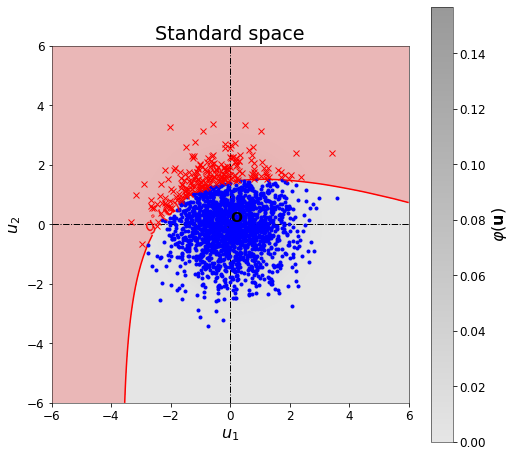

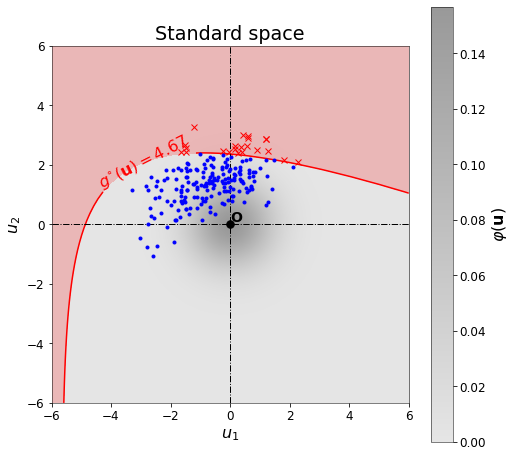

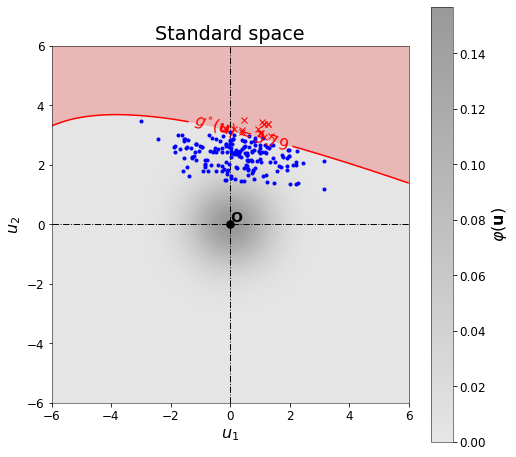

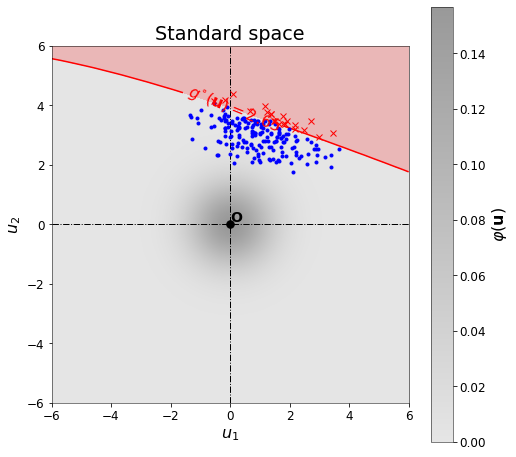

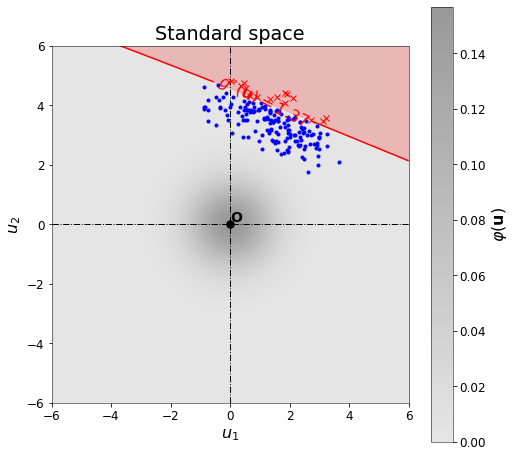

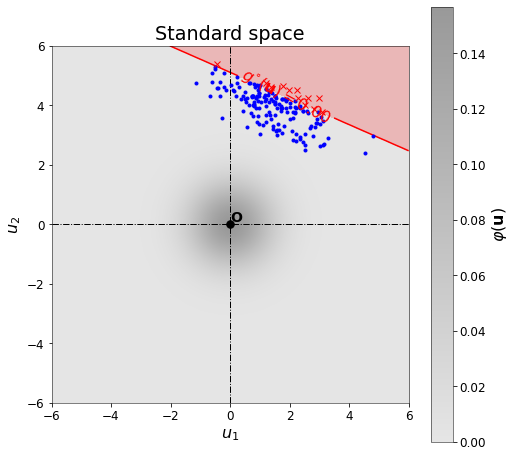

In [27]:
for step in range(ss_algorithm.getNumberOfSteps()):
    mask = True
    N = ss_algorithm.getMaximumOuterSampling() * ss_algorithm.getBlockSize()
    thresholds = ss_algorithm.getThresholdPerStep()
    input_sample = np.array(g.getInputHistory())[step * N:(step + 1) * N]
    input_sample = np.array(input_distribution.getIsoProbabilisticTransformation()(input_sample))
    output_sample = np.ravel(g.getOutputHistory())[step * N:(step + 1) * N]
    ax, data_plot = plot_in_standard_space(g0=thresholds[step])
    if step > 0:
        mask = np.ravel(g.getOutputHistory())[(step - 1) * N:step * N] <= thresholds[step - 1]

    ax.plot(input_sample[mask][output_sample[mask] > thresholds[step], 0],
            input_sample[mask][output_sample[mask] > thresholds[step], 1], 'b.')
    _ = ax.plot(input_sample[mask][output_sample[mask] <= thresholds[step], 0],
                input_sample[mask][output_sample[mask] <= thresholds[step], 1], 'rx')

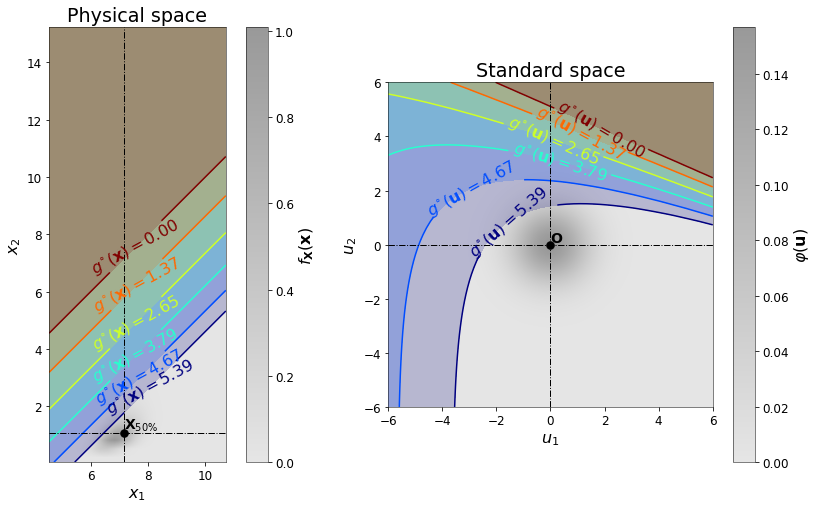

In [28]:
thresholds = np.ravel(ss_algorithm.getThresholdPerStep())
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax, data_plot = plot_in_physical_space(g0=None, ax=ax)
colors = plt.matplotlib.cm.jet(np.linspace(0, 1., thresholds.size))
for threshold, color in zip(thresholds, colors):
    c = ax.contourf(data_plot['x1_plot'], data_plot['x2_plot'], data_plot['gx_plot'],
                    [-np.inf, threshold], colors=[color], alpha=.2)
    c = ax.contour(data_plot['x1_plot'], data_plot['x2_plot'], data_plot['gx_plot'],
                   [threshold], colors=[color], linestyles='solid')
    plt.clabel(c, fmt=FormatFaker('$g^{\circ}(\mathbf{x}) = %.2f$' % threshold))
ax = fig.add_subplot(122)
ax, data_plot = plot_in_standard_space(g0=None, ax=ax)
colors = plt.matplotlib.cm.jet(np.linspace(0, 1., thresholds.size))
for threshold, color in zip(thresholds, colors):
    c = ax.contourf(data_plot['u1_plot'], data_plot['u2_plot'], data_plot['gu_plot'],
                    [-np.inf, threshold], colors=[color], alpha=.2)
    c = ax.contour(data_plot['u1_plot'], data_plot['u2_plot'], data_plot['gu_plot'],
                   [threshold], colors=[color], linestyles='solid')
    plt.clabel(c, fmt=FormatFaker('$g^{\circ}(\mathbf{u}) = %.2f$' % threshold))